# Overlay(CTとAnnotationの重ね合わせ)

In [9]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import time
import nibabel as nib
import ctvis
from glob import glob
from pathlib import Path
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### **private function**
- *get_df のように script内でしか呼ばれない関数*
    - 接頭辞に _ (アンダースコア)をつける
    - **この　script　内でしか呼ばれませんと明示的に伝える**


- <u>呼ぼうとすれば呼べるが...</u>
    - *外から呼ばれるよな事は想定していない関数ですよ！という意思表示*
    - *pythonの処理的には関係が無いので注意する*


#### **from　ctvis　import　*　( アスタリスク )** での　import
- *( * : アスタリスク )で import した時には _ (アンダースコア)の関数は呼び出せない*

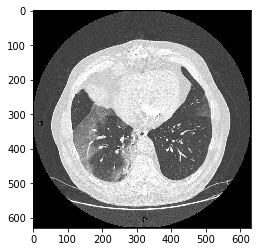

In [10]:
df = ctvis.get_df_all('../public-covid-data')
index = 0
volume = ctvis.load_nifti(df.iloc[index]['FilePathImage'])
mask = ctvis.load_nifti(df.iloc[index]['FilePathMask'])
mask_color = ctvis.label_color(mask)
volume_gray = ctvis.hu_to_gray(volume)
plt.imshow(volume_gray[:, :, 30])

In [11]:
a = np.array([[[146, 100, 100]]])
a.shape

(1, 1, 3)

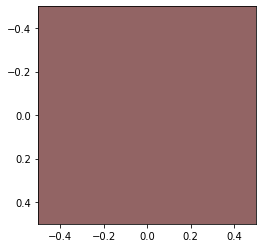

In [12]:
plt.imshow(a)

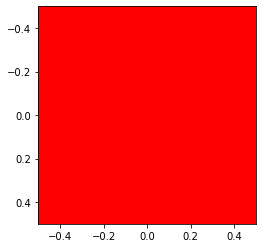

In [13]:
original = np.array([[[100, 100, 100]]])
color = np.array([[[255, 0, 0]]])
plt.imshow(color)

[[[146  70  70]]]


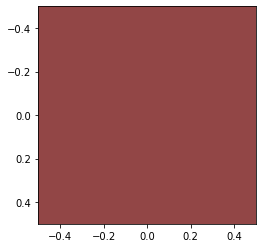

In [14]:
overlay = (0.7*original + 0.3*color).astype(np.uint8)
print(overlay)
plt.imshow(overlay)

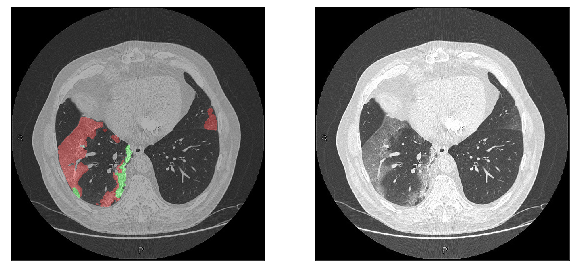

In [15]:
overlay = (0.7*volume_gray + 0.3*mask_color).astype(np.uint8)
data = [overlay[:, :, 30], volume_gray[:, :, 30]]
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
for idx, i in enumerate(data):
    axes[idx].imshow(i, cmap='gray')
    axes[idx].set_xticks(ticks=[])  # 横軸のメモリを消す
    axes[idx].set_yticks(ticks=[])  # 縦軸のメモリを消す

- *2つの画像を比べると若干暗くなっている*
    - **全ての pix に対して　0.7 を掛けているので mask が無い部分も 0.7 掛けられている**


- <u>pix の値が減るということは、光が減るという事なので暗くなる</u>
    - **元の画像の明るさが、変化してしまうのは CT 画像において問題になってくる**


- **np.where(a > 0, Trueの時の処理, Falseの時の処理)**

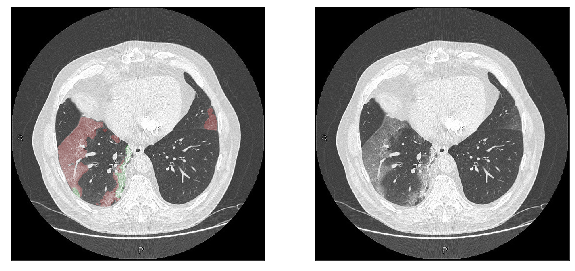

In [16]:
overlay = np.where(mask_color > 0, (0.7*volume_gray + 0.3*mask_color).astype(np.uint8), volume_gray)
data = [overlay[:, :, 30], volume_gray[:, :, 30]]
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
for idx, i in enumerate(data):
    axes[idx].imshow(i, cmap='gray')
    axes[idx].set_xticks(ticks=[])  # 横軸のメモリを消す
    axes[idx].set_yticks(ticks=[])  # 縦軸のメモリを消す

### *元の画像の色は改善されたが　mask　の色が薄い*

In [17]:
# np.where(mask > 0, True, False)
mask_filter = np.greater(mask, 0)
mask_filter.shape

(630, 630, 45)

In [18]:
mask_filter = np.stack([mask_filter, mask_filter, mask_filter], axis=-1)
mask_filter.shape

(630, 630, 45, 3)

### 元の mask data を 0 より大きい値を True 小さい値を False
- stack（ ） を使用して　３つのチャネルにした

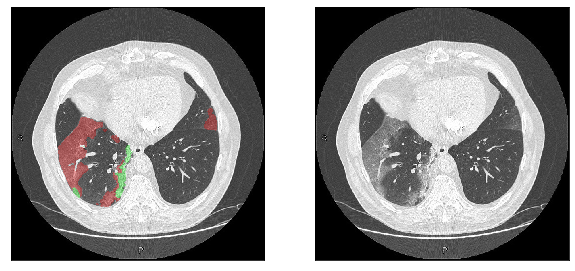

In [19]:
overlay = np.where(mask_filter, (0.7*volume_gray + 0.3*mask_color).astype(np.uint8), volume_gray)
data = [overlay[:, :, 30], volume_gray[:, :, 30]]
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
for idx, i in enumerate(data):
    axes[idx].imshow(i, cmap='gray')
    axes[idx].set_xticks(ticks=[])  # 横軸のメモリを消す
    axes[idx].set_yticks(ticks=[])  # 縦軸のメモリを消す

## 上記を関数にする

In [20]:
def overlay(gray_volume, mask_volume, mask_color, alpha):
    mask_filter = np.greater(mask_volume, 0)
    mask_filter = np.stack([mask_filter, mask_filter, mask_filter], axis=-1)
    overlayed= np.where(mask_filter,
                       ((1-alpha)*gray_volume + alpha*mask_color).astype(np.uint8), gray_volume)
    
    return overlayed

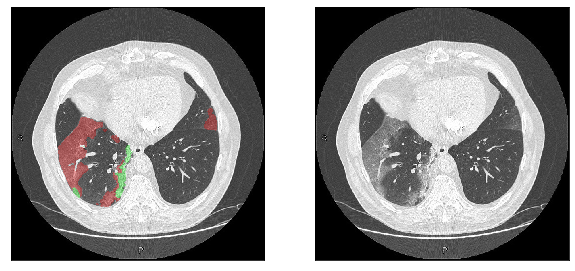

In [21]:
overlayed = overlay(volume_gray, mask, mask_color, alpha=0.3)
data = [overlayed[:, :, 30], volume_gray[:, :, 30]]
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
for idx, i in enumerate(data):
    axes[idx].imshow(i, cmap='gray')
    axes[idx].set_xticks(ticks=[])  # 横軸のメモリを消す
    axes[idx].set_yticks(ticks=[])  # 縦軸のメモリを消す

## script からの読み込み Test

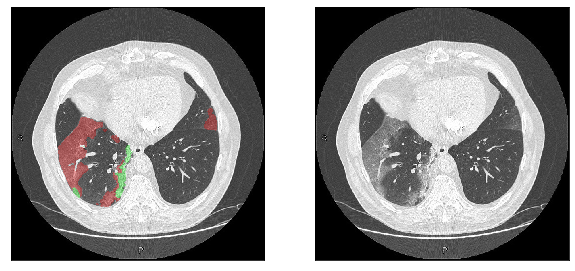

In [22]:
overlayed = ctvis.overlay(volume_gray, mask, mask_color, alpha=0.3)
data = [overlayed[:, :, 30], volume_gray[:, :, 30]]
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
for idx, i in enumerate(data):
    axes[idx].imshow(i, cmap='gray')
    axes[idx].set_xticks(ticks=[])  # 横軸のメモリを消す
    axes[idx].set_yticks(ticks=[])  # 縦軸のメモリを消す